# Messing With MEDA

[MEDA](https://atmos.nmsu.edu/data_and_services/atmospheres_data/PERSEVERANCE/meda.html) refers the to the package of environmental sensors on the Perserverance rover that's currently rolling around in Jezero Crater on Mars. It stands for "*Mars Environmental Dynamics Analyzer*" and is the successor to [REMS](https://mars.nasa.gov/msl/spacecraft/instruments/rems/).

I downloaded and reformatted a big batch of the presently available data, which comes in tabular ascii format (csv). Zipped up, all of the data is about 3 GB, but much larger uncompressed. The [`extract.py`](https://github.com/markmbaum/MEDA/blob/main/scripts/extract.py) script pulls selected tables out of the text files and dumps them into [feather](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_feather.html) files, which are much more space efficient and faster to read. Then the [`join.py`](https://github.com/markmbaum/MEDA/blob/main/scripts/join.py) script joins (of course) the different tables based on their time stamps, producing a single feather file with all the available information.

Unfortunately, after inspection, a lot of the data are missing or suspicious. They data products are classified as "calibrated" or "derived" and it appears that virtually all of the calibrated data, including temperature, requires further processing and correction. The only quantity that seems reliable is atmospheric pressure. There are some similar issues with the publicly available REMS data...

I wanted to find something interesting to do with all the data. The only usable variable is pressure and the measurements are quite irregularly spaced. This makes standard time series modeling pretty challenging. So, I decided to mess around with vanilla, dense neural networks.

Mars has a very interesting seasonal cycle in atmopsheric pressure. But, because the rover has only been on the ground for part of a martian year, it hasn't seen a full seasonal cycle yet. So, I thought it might be interesting to see how networks with different structures will forecast the rest of the seasonal pressure cycle, trained only on what has been measured so far.

**the short version** 
* **I have environmental (weather) data from the Perserverance Rover on Mars.**
* **Most of it is suspicious or sparse. Only the atmospheric pressure looks good.**
* **Observations are irregularly spaced and often missing.**
* **Just to tinker, I use neural nets to forecast the seasonal pressure cycle.**
* **The only inputs/features are sinusoids representing diurnal and annual signals.**
* **I use the Julia ecosystem, notably [Flux.jl](https://fluxml.ai/Flux.jl/stable/) for the modeling.**

In [1]:
#DrWatson is a project management package that helps with the environment, path strings, etc...
using DrWatson
@quickactivate "Messing With MEDA"

In [2]:
#load all the other packages
using Arrow
using DataFrames
using Flux
using Flux: mse, DataLoader, train!, params
using ParameterSchedulers
using ProgressMeter: @showprogress
using PyPlot
using Random: shuffle
using StatsBase: mean, std, zscore
plt.rc("font", size=5);

## Load and Process Data

In [3]:
#load the data
meda = DrWatson.datadir("pro", "meda.feather") |> Arrow.Table |> DataFrame;

In [4]:
Base.show(meda)

24571012×15 DataFrame
      Row │ sol     hr      min     sec     air_temp  ground_temp  solar_longi ⋯
          │ Int64?  Int64?  Int64?  Int64?  Float64?  Float64?     Float64?    ⋯
──────────┼─────────────────────────────────────────────────────────────────────
        1 │      1      15      28       1    274.31       298.79              ⋯
        2 │      1      15      28       2    273.72       298.73
        3 │      1      15      28       3    273.56       298.77
        4 │      1      15      28       4    272.23       298.73
        5 │      1      15      28       5    273.13       298.73              ⋯
        6 │      1      15      28       6    272.92       298.68
        7 │      1      15      28       7    272.36       298.67
        8 │      1      15      28       8    271.17       298.66
        9 │      1      15      28       9    271.14       298.7               ⋯
       10 │      1      15      28      10    271.2        298.66
       11 │      1      15    

There are about 24.5 million observations in the table. There are a bunch of different columns, like `air_temp`, but unfortunatly if you start plotting these columns they look very suspicious. We're stuck with the pressure only.

The data are stamped at every second. That's unnecessarily high frequency, so I average all the measurements within a single minute.

In [5]:
df = combine(
    groupby(
        meda,
        [:sol, :hr, :min]
    ),
    names(meda) .=> mean .=> names(meda)
);

The discrete time columns (sol, hour, minute, second) are not easily usable. So I fold all the temporal information into a single column representing fractional sols (a "sol" is a day on Mars), and get rid of all the extraneous columns.

In [6]:
df.sol = df.sol + df.hr/24 + df.min/(24*60) + df.sec/(24*3600)
df.sol .-= minimum(df.sol)
select!(df, :sol, :pressure=>:P)
Base.show(df)

202615×2 DataFrame
    Row │ sol            P       
        │ Float64        Float64 
────────┼────────────────────────
      1 │   0.0          715.856
      2 │   0.000678022  715.817
      3 │   0.00137372   715.755
      4 │   0.00209382   715.636
      5 │   0.00276803   715.556
      6 │   0.0034532    715.516
      7 │   0.00413763   715.562
      8 │   0.00481262   715.469
      9 │   0.00554755   715.338
     10 │   0.00622683   715.331
     11 │   0.00690642   715.3
   ⋮    │       ⋮           ⋮
 202606 │ 297.45         631.233
 202607 │ 297.451        631.235
 202608 │ 297.451        631.232
 202609 │ 297.452        631.239
 202610 │ 297.452        631.235
 202611 │ 297.461        630.27
 202612 │ 297.462        630.554
 202613 │ 297.462        630.709
 202614 │ 297.463        630.778
 202615 │ 297.464        630.787
              202594 rows omitted

Now we can take a look at our 202,594 atmospheric pressure observations.

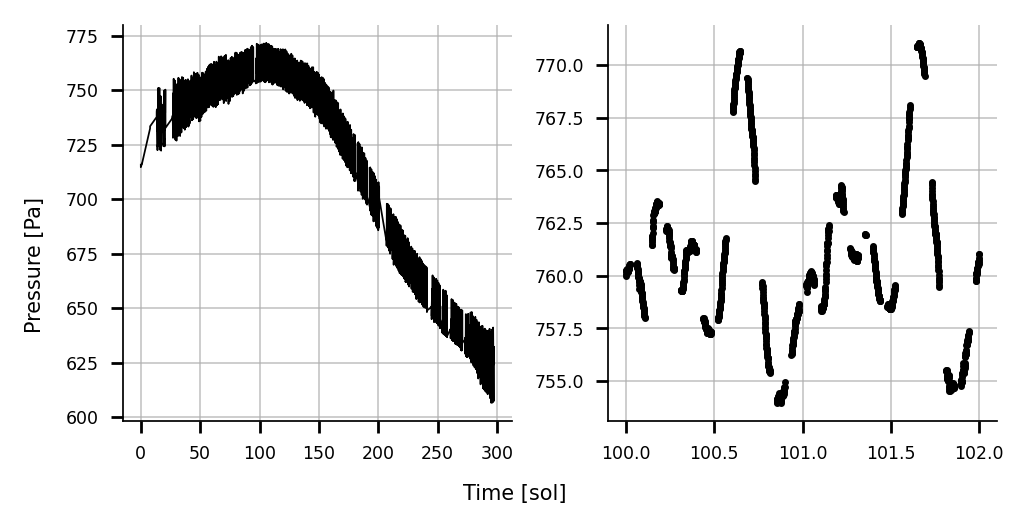

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(4,2), constrained_layout=true)
axs[1].plot(df.sol, df.P, "k", linewidth=0.5)
m = (@. 100 < df.sol < 102)
axs[2].plot(df.sol[m], df.P[m], ".", markersize=2, color="k", linewidth=0.5)
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");

We can see the first part of the seasonal pressure cycle in the plot on the left. A martian year is 668 sols and we have about 298 sols of data, or 44 % of a full cycle. On the right, we have slice of data over just two sols. It's pretty clear how irregularly spaced the data are. There is also a lot of intra-day variability. I don't know the cause of that variability, but it would be interesting to find out. It must have something to do with crater-scale weather processes in/around Jezero.

## Generate Temporal Signals

Next, we further engineer the temporal information. "Fractional sols" is not a very meaningful quantity. We know that there will be pressure cycles every year and every sol. So, as is fairly standard practice, we take a cue from spectral analysis and create sinusoids with diurnal and annual periods. **These will be the only predictors for the eventual forecast.** Because these signals are always between -1 and 1, I won't bother with standardizing them.

In [8]:
#function to generate "time of year" sinusoids
TOY(sol::AbstractVector) = (sin.(2π*sol/668), cos.(2π*sol/668))

#function to generate "time of day" sinusoids
TOD(sol::AbstractVector) = (sin.(2π*sol), cos.(2π*sol))

# sinusoidal representations of time of year and time of day
df[!,:toys], df[!,:toyc] = TOY(df.sol)
df[!,:tods], df[!,:todc] = TOD(df.sol);

In [9]:
#prediction columns (all temporal sinusoids)
pred = [:toys, :toyc, :tods, :todc]
#target/label column
targ = :P #just the pressure

#convert into nice matrices
X = df[!,pred] |> Matrix |> transpose |> Matrix .|> Float32
y = df[!,targ] |> zscore |> transpose |> Matrix .|> Float32
#store the mean and std of the pressure to un-standardize predictions
μ = mean(df.P)
σ = std(df.P);

## Train a Single Model

Now we can train. The following is a general function for training a dense neural network with an arbitrary number of layers and an arbitrary number of perceptrons in each hidden layer. The hidden layers are all `elu` activated. The input size of the first layer is always 4 and the output size of the last layer is always 1. Hidden layers will all have the same number of perceptrons. The learning rate is scheduled to have a decaying cyclical form.

Also, in this context, i'm not really worried about overfitting. I want to produce models that fit the data very well, then look at how they "decide" to extrapolate. That said, the training function below provides optional L2 regularization on all model parameters.

In [10]:
function train(nlayer, hlayer, X, y; nepoch=32, nbatch=128, λ=0.0, verbose=false)
    @assert nlayer >= 3
    #construct hidden layers as specified
    hidden = fill(Dense(hlayer => hlayer, elu), nlayer - 2)
    #construct a model
    model = Chain(
        Dense(size(X,1)=>hlayer, elu),
        hidden...,
        Dense(hlayer => 1)
    )
    p = params(model)
    #define the loss function
    loss(x, y) = mse(model(x), y) + λ*sum(𝓅 -> sum(abs2,𝓅), p)
    loss(z) = loss(z...)
    #define training strategy
    dl = DataLoader((data=X, labels=y), batchsize=nbatch, shuffle=true)
    opt = ParameterSchedulers.Scheduler(SinExp(λ0=1e-2, λ1=5e-4, γ=0.9, period=6), ADAM())
    #train the model
    history = zeros(nepoch+1)
    history[1] = loss(X, y)
    @showprogress for i ∈ 1:nepoch
        if verbose
            println("epoch $i")
            println("  loss: $(history[i])")
        end
        train!(loss, p, dl, opt)
        history[i+1] = loss(X, y)
    end
    verbose && println("final loss: $(history[end])")
    return(model, history)
end;

Let's test out a single case with a total of 4 layers, 16 perceptrons in the hidden layers, and no regularization.

Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


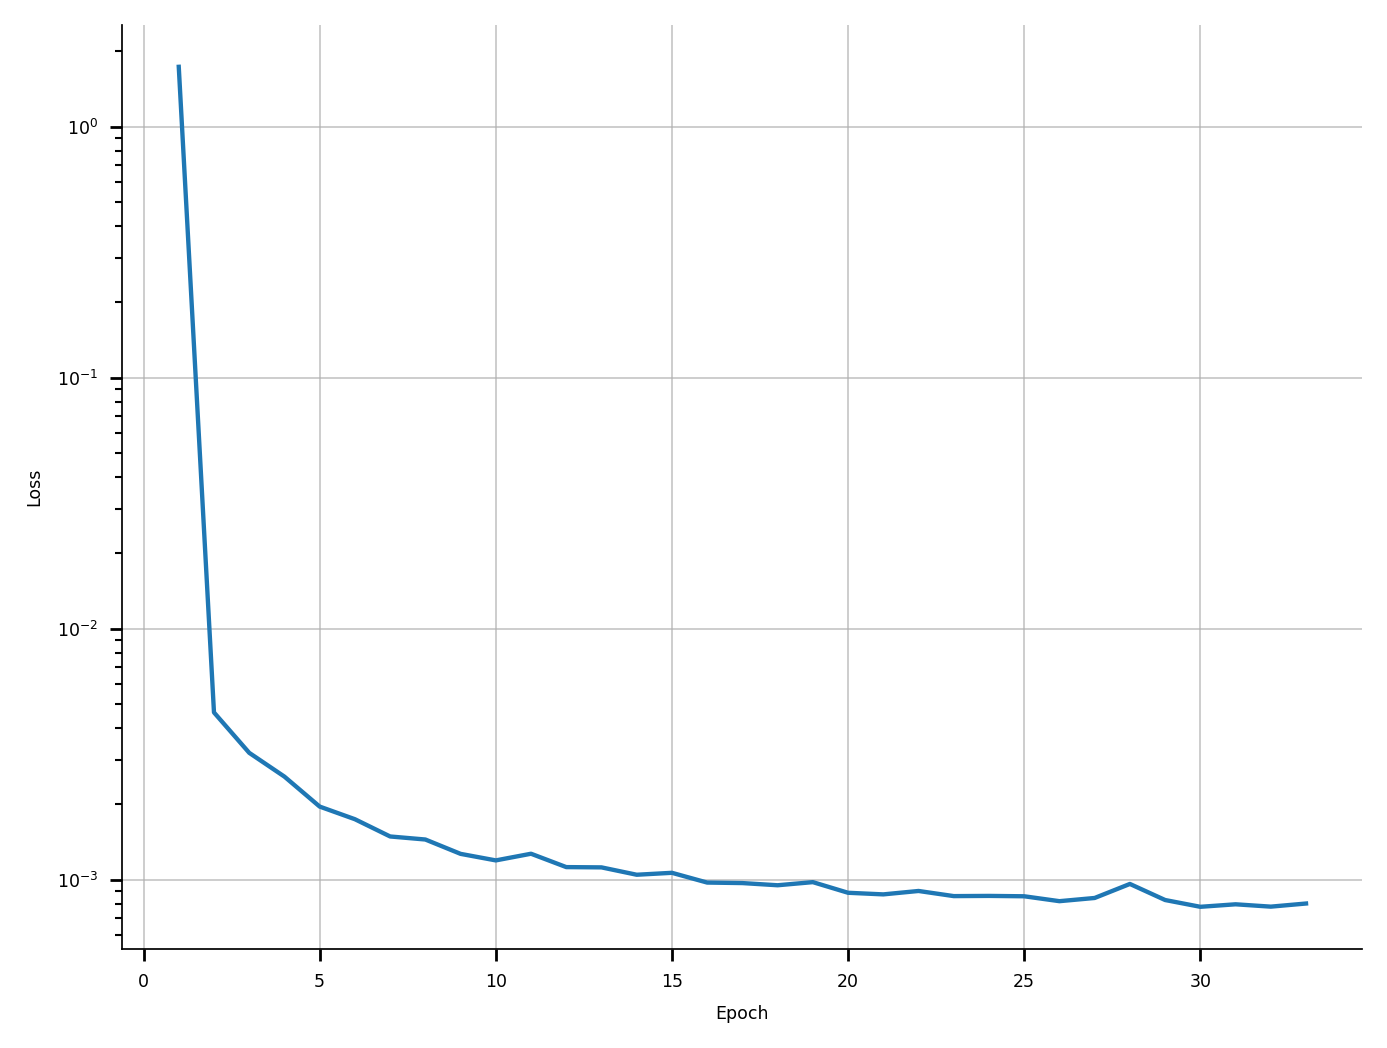

In [11]:
model, history = train(4, 16, X, y);
plt.semilogy(1:length(history), history)
plt.xlabel("Epoch")
plt.ylabel("Loss");

In [12]:
model

Chain(
  Dense(4 => 16, elu),                  # 80 parameters
  Dense(16 => 16, elu),                 # 272 parameters
  Dense(16 => 16, elu),                 # 272 parameters
  Dense(16 => 1),                       # 17 parameters
)         # Total: 6 trainable arrays, 369 parameters,
          # plus 2 non-trainable, 272 parameters, summarysize 1.863 KiB.

Nice. The model has about 350 trainable parameters. The test loss stabilizes well below 1e-2.

Let's use the model for a seasonal "forecast" and also see how it looks on the diurnal cycle.

In [13]:
#this function stacks the "time of year" and "time of day" sinusoids into a single matrix
function sinusoids(sol::AbstractVector)
    toys, toyc = TOY(sol)
    tods, todc = TOD(sol)
    hcat(toys, toyc, tods, todc) |> transpose |> Matrix .|> Float32
end;

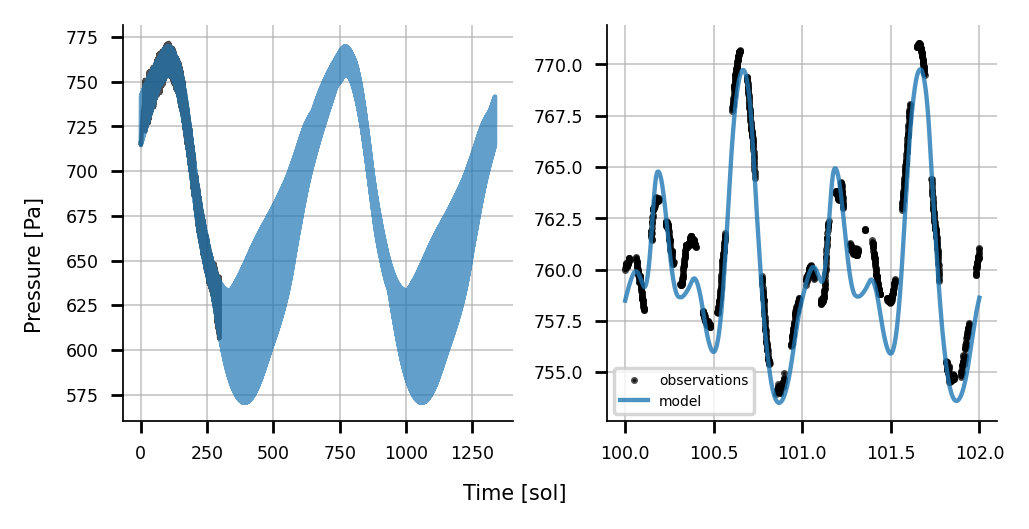

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(4,2), constrained_layout=true)
sol = LinRange(0, 668*2, 1_000_000)
axs[1].plot(df.sol, df.P, color="k", alpha=0.7)
axs[1].plot(sol, μ .+ σ*(sinusoids(sol) |> model |> vec), alpha=0.7)
sol = LinRange(100, 102, 100_000)
m = (@. 100 < df.sol < 102)
axs[2].plot(df.sol[m], df.P[m], color="k", ".", markersize=2, alpha=0.7, label="observations")
axs[2].plot(sol, μ .+ σ*(sinusoids(sol) |> model |> vec), alpha=0.8, label="model")
axs[2].legend(fontsize=4)
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");

Neat.

On the left, we see that the model matches the data quite well over the initial ~300 days. When the data stop, the model carries on with a mind of its own. On the right, we see that the model matches intra-sol variability fairly well too. The model could reasonably be used to fill in all the data gaps that are evident in the first plot way above.

**We know what the seasonal cycle [should look like](https://github.com/markmbaum/REMS), and this is not it**. To properly represent the cycle, we need a more complete representation of the full year. Nevertheless, the model produces a clear seasonal cycle, repeating every 668 days, because we demanded that it do so.

Next, I'll experiment a little with different model architecture, changing the number of layers and the number of perceptrons in each hidden layer. This time, 12 epochs for all training sessions just to be sure.

## Train a Grid of Models

In [15]:
function traingrid(hlayer, nlayer, λ=0.0)
    #allocate space for all the models
    models = Matrix{Flux.Chain}(undef, length(hlayer), length(nlayer))
    #train them all!
    for i ∈ 1:length(hlayer), j ∈ 1:length(nlayer)
        models[i,j], history = train(nlayer[j], hlayer[i], X, y, λ=λ)
        println("$(nlayer[j]) layers, $(hlayer[i]) perceptrons, loss: $(history[end])")
    end
    return(models)
end

#numer of layers
nlayer = [4, 6, 8, 10]
#size of layers
hlayer = [16, 32, 48, 64]

#train models
models = traingrid(hlayer, nlayer);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15
Progress: 100%|█████████████████████████████████████████| Time: 0:02:11
Progress: 100%|█████████████████████████████████████████| Time: 0:02:38
Progress: 100%|█████████████████████████████████████████| Time: 0:03:08
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
Progress: 100%|█████████████████████████████████████████| Time: 

4 layers, 16 perceptrons, loss: 0.0007710924255661666
6 layers, 16 perceptrons, loss: 0.0006619665655307472
8 layers, 16 perceptrons, loss: 0.0008454216294921935
10 layers, 16 perceptrons, loss: 0.0007271648501046002
4 layers, 32 perceptrons, loss: 0.0006993689457885921
6 layers, 32 perceptrons, loss: 0.0007268596673384309
8 layers, 32 perceptrons, loss: 0.0005682923947460949
10 layers, 32 perceptrons, loss: 0.0006259254296310246
4 layers, 48 perceptrons, loss: 0.0005992624792270362
6 layers, 48 perceptrons, loss: 0.0005775755853392184
8 layers, 48 perceptrons, loss: 0.00048289960250258446
10 layers, 48 perceptrons, loss: 0.000620465085376054
4 layers, 64 perceptrons, loss: 0.0006650795694440603
6 layers, 64 perceptrons, loss: 0.0005218061269260943
8 layers, 64 perceptrons, loss: 0.00041917694034054875
10 layers, 64 perceptrons, loss: 0.0005092533538118005


All trained. Here is the "seasonal forecast" for all 16 models with *no regularization*. 

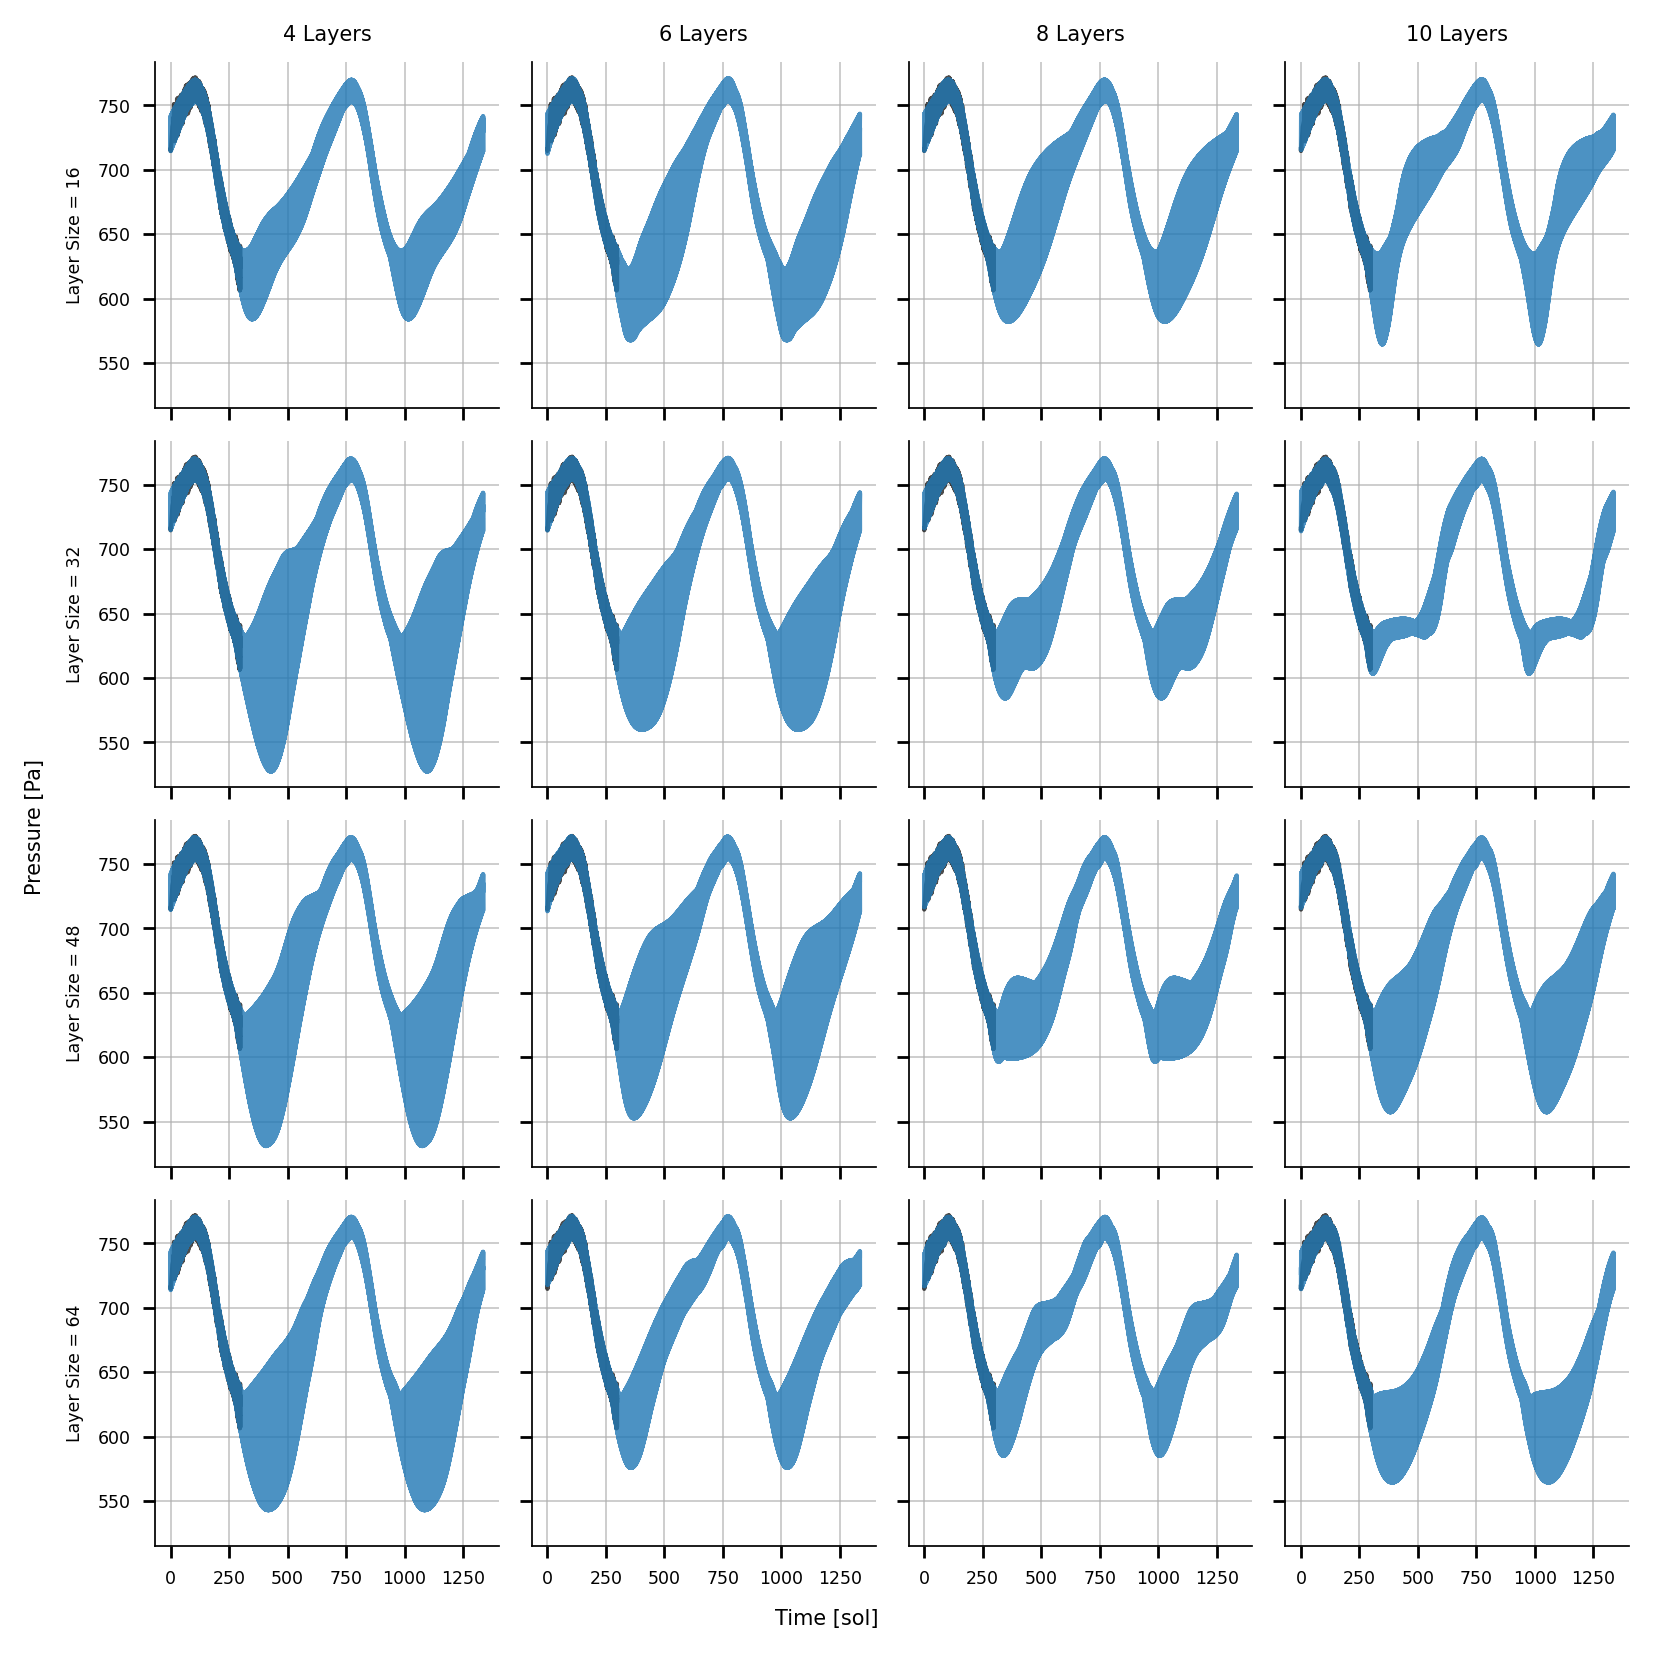

In [16]:
fig, axs = plt.subplots(
    length(hlayer),
    length(nlayer),
    figsize=(6.5,6.5),
    sharex=true,
    sharey=true,
    constrained_layout=true
)
sol = LinRange(0, 668*2, 100_000)
∿ = sinusoids(sol)
for i ∈ 1:length(hlayer), j ∈ 1:length(nlayer)
    axs[i,j].plot(df.sol, df.P, color="k", alpha=0.7)
    axs[i,j].plot(sol, μ .+ σ*(∿ |> models[i,j] |> vec), alpha=0.8)
end
for i ∈ 1:length(hlayer)
    axs[i,1].set_ylabel("Layer Size = $(hlayer[i])")
end
for j ∈ 1:length(nlayer)
    axs[1,j].set_title("$(nlayer[j]) Layers")
end
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");

We are not expecting any of the models to recover the true seasonal cycle, so they can't be evaluated in any rigorous way here. Nevertheless, it's interesting to stare into the shapes for a while. Some of them are wild and change non-smoothly after the window of data.

It's also worth mentioning that I haven't fixed the randomization of the data splitting. If we reran everything, it may look different.

Here is the intra-day dynamic for each model.

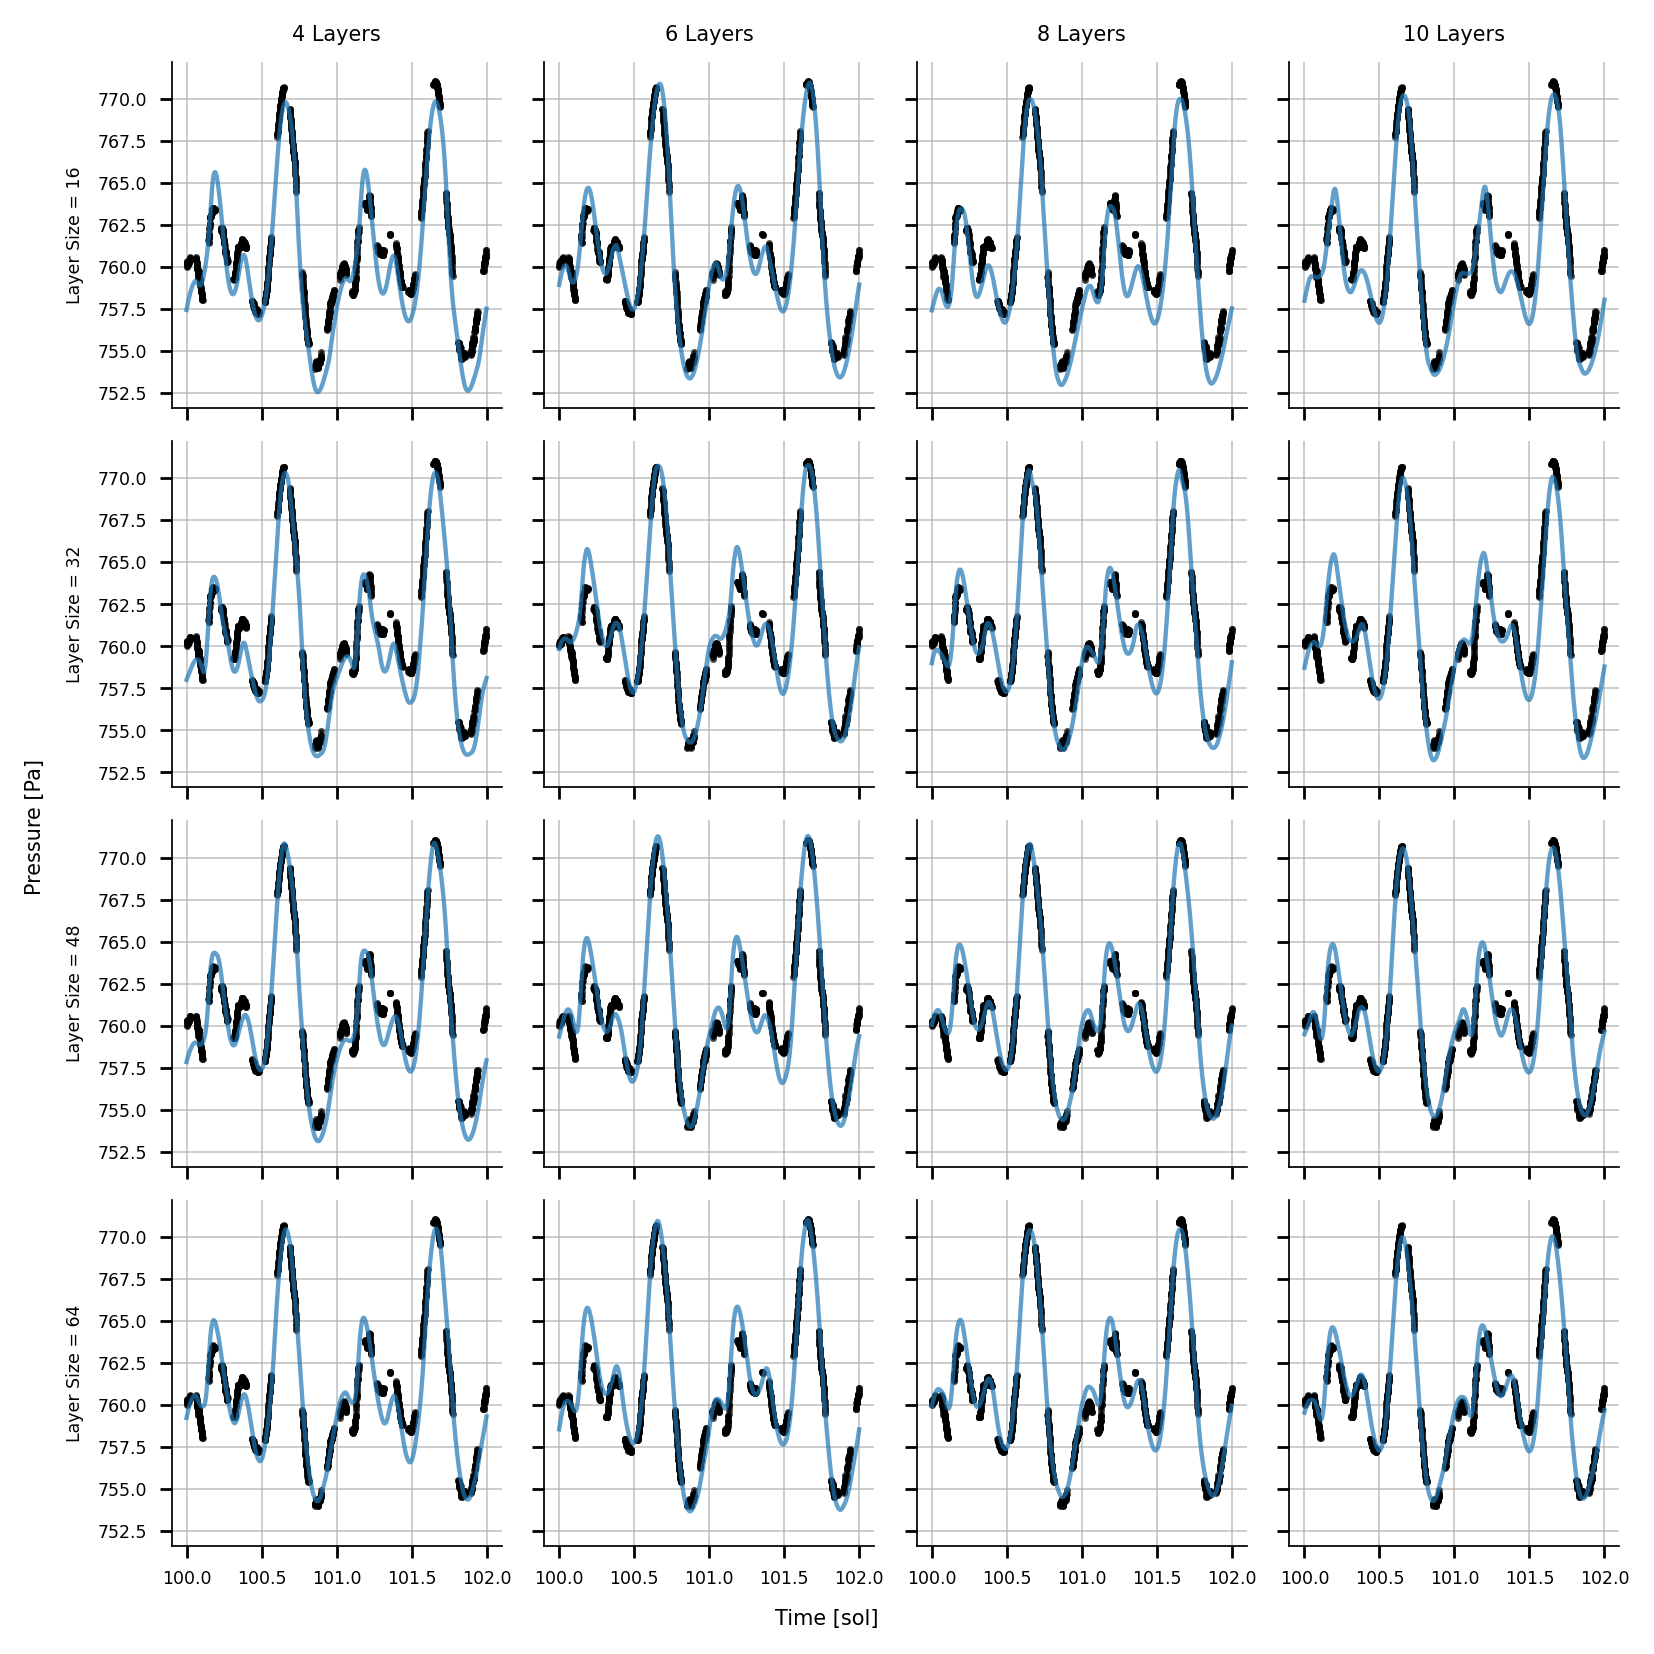

In [17]:
fig, axs = plt.subplots(
    length(hlayer),
    length(nlayer),
    figsize=(6.5,6.5),
    sharex=true,
    sharey=true,
    constrained_layout=true
)
sol = LinRange(100, 102, 100_000)
∿ = sinusoids(sol)
m = (@. 100 < df.sol < 102)
for i ∈ 1:length(hlayer), j ∈ 1:length(nlayer)
    axs[i,j].plot(df.sol[m], df.P[m], color="k", alpha=0.7, ".", markersize=2)
    axs[i,j].plot(sol, μ .+ σ*(∿ |> models[i,j] |> vec), alpha=0.7)
end
for i ∈ 1:length(hlayer)
    axs[i,1].set_ylabel("Layer Size = $(hlayer[i])")
end
for j ∈ 1:length(nlayer)
    axs[1,j].set_title("$(nlayer[j]) Layers")
end
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");

Now we train the exact same set of models with a small amount of L2 regularization on all model parameters.

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08
Progress: 100%|█████████████████████████████████████████| Time: 0:02:37
Progress: 100%|█████████████████████████████████████████| Time: 0:03:10
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
Progress: 100%|█████████████████████████████████████████| Time: 

4 layers, 16 perceptrons, loss: 0.0035119074273854494
6 layers, 16 perceptrons, loss: 0.0031610728915780783
8 layers, 16 perceptrons, loss: 0.002970379600860179
10 layers, 16 perceptrons, loss: 0.0028613417193293572
4 layers, 32 perceptrons, loss: 0.0037240571957081556
6 layers, 32 perceptrons, loss: 0.003099196527525783
8 layers, 32 perceptrons, loss: 0.0030717873735353353
10 layers, 32 perceptrons, loss: 0.003343807012960315
4 layers, 48 perceptrons, loss: 0.0034277627443894745
6 layers, 48 perceptrons, loss: 0.003243749842979014
8 layers, 48 perceptrons, loss: 0.0031088941860944034
10 layers, 48 perceptrons, loss: 0.0031378530273213985
4 layers, 64 perceptrons, loss: 0.0034529057310894134
6 layers, 64 perceptrons, loss: 0.003207831372320652
8 layers, 64 perceptrons, loss: 0.0025460621191188693
10 layers, 64 perceptrons, loss: 0.0023936786375939848


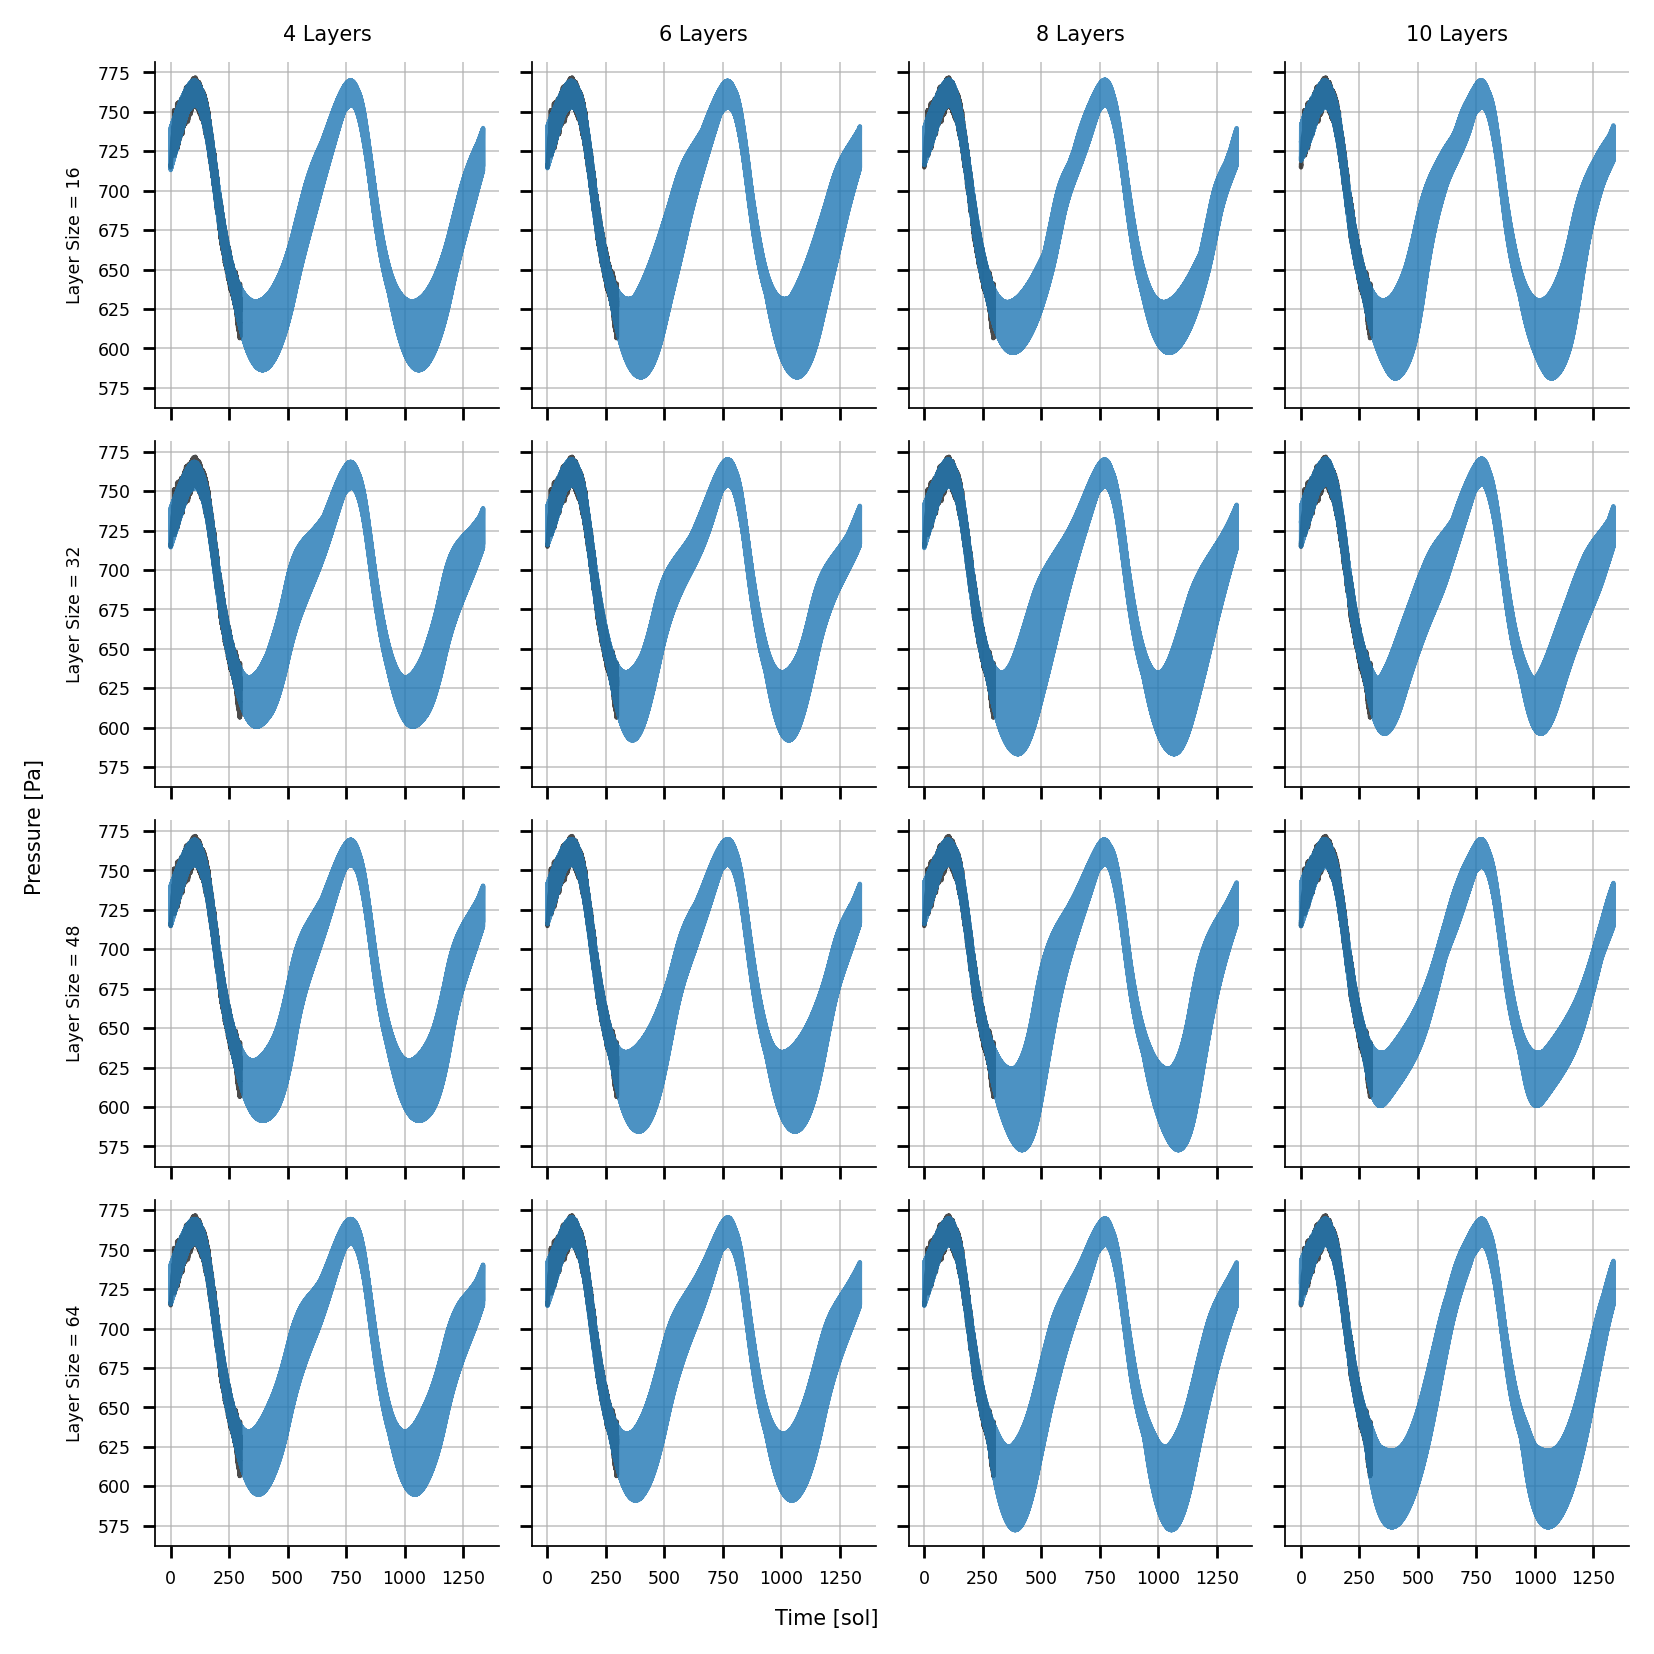

In [20]:
#train models
models = traingrid(hlayer, nlayer, 1e-4);

#another round of plots
fig, axs = plt.subplots(
    length(hlayer),
    length(nlayer),
    figsize=(6.5,6.5),
    sharex=true,
    sharey=true,
    constrained_layout=true
)
sol = LinRange(0, 668*2, 100_000)
∿ = sinusoids(sol)
for i ∈ 1:length(hlayer), j ∈ 1:length(nlayer)
    axs[i,j].plot(df.sol, df.P, color="k", alpha=0.7)
    axs[i,j].plot(sol, μ .+ σ*(∿ |> models[i,j] |> vec), alpha=0.8)
end
for i ∈ 1:length(hlayer)
    axs[i,1].set_ylabel("Layer Size = $(hlayer[i])")
end
for j ∈ 1:length(nlayer)
    axs[1,j].set_title("$(nlayer[j]) Layers")
end
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");

Regularization has effectively damped with the exotic behavior in the extrapolation. Here is another look at the intra-day cycles.

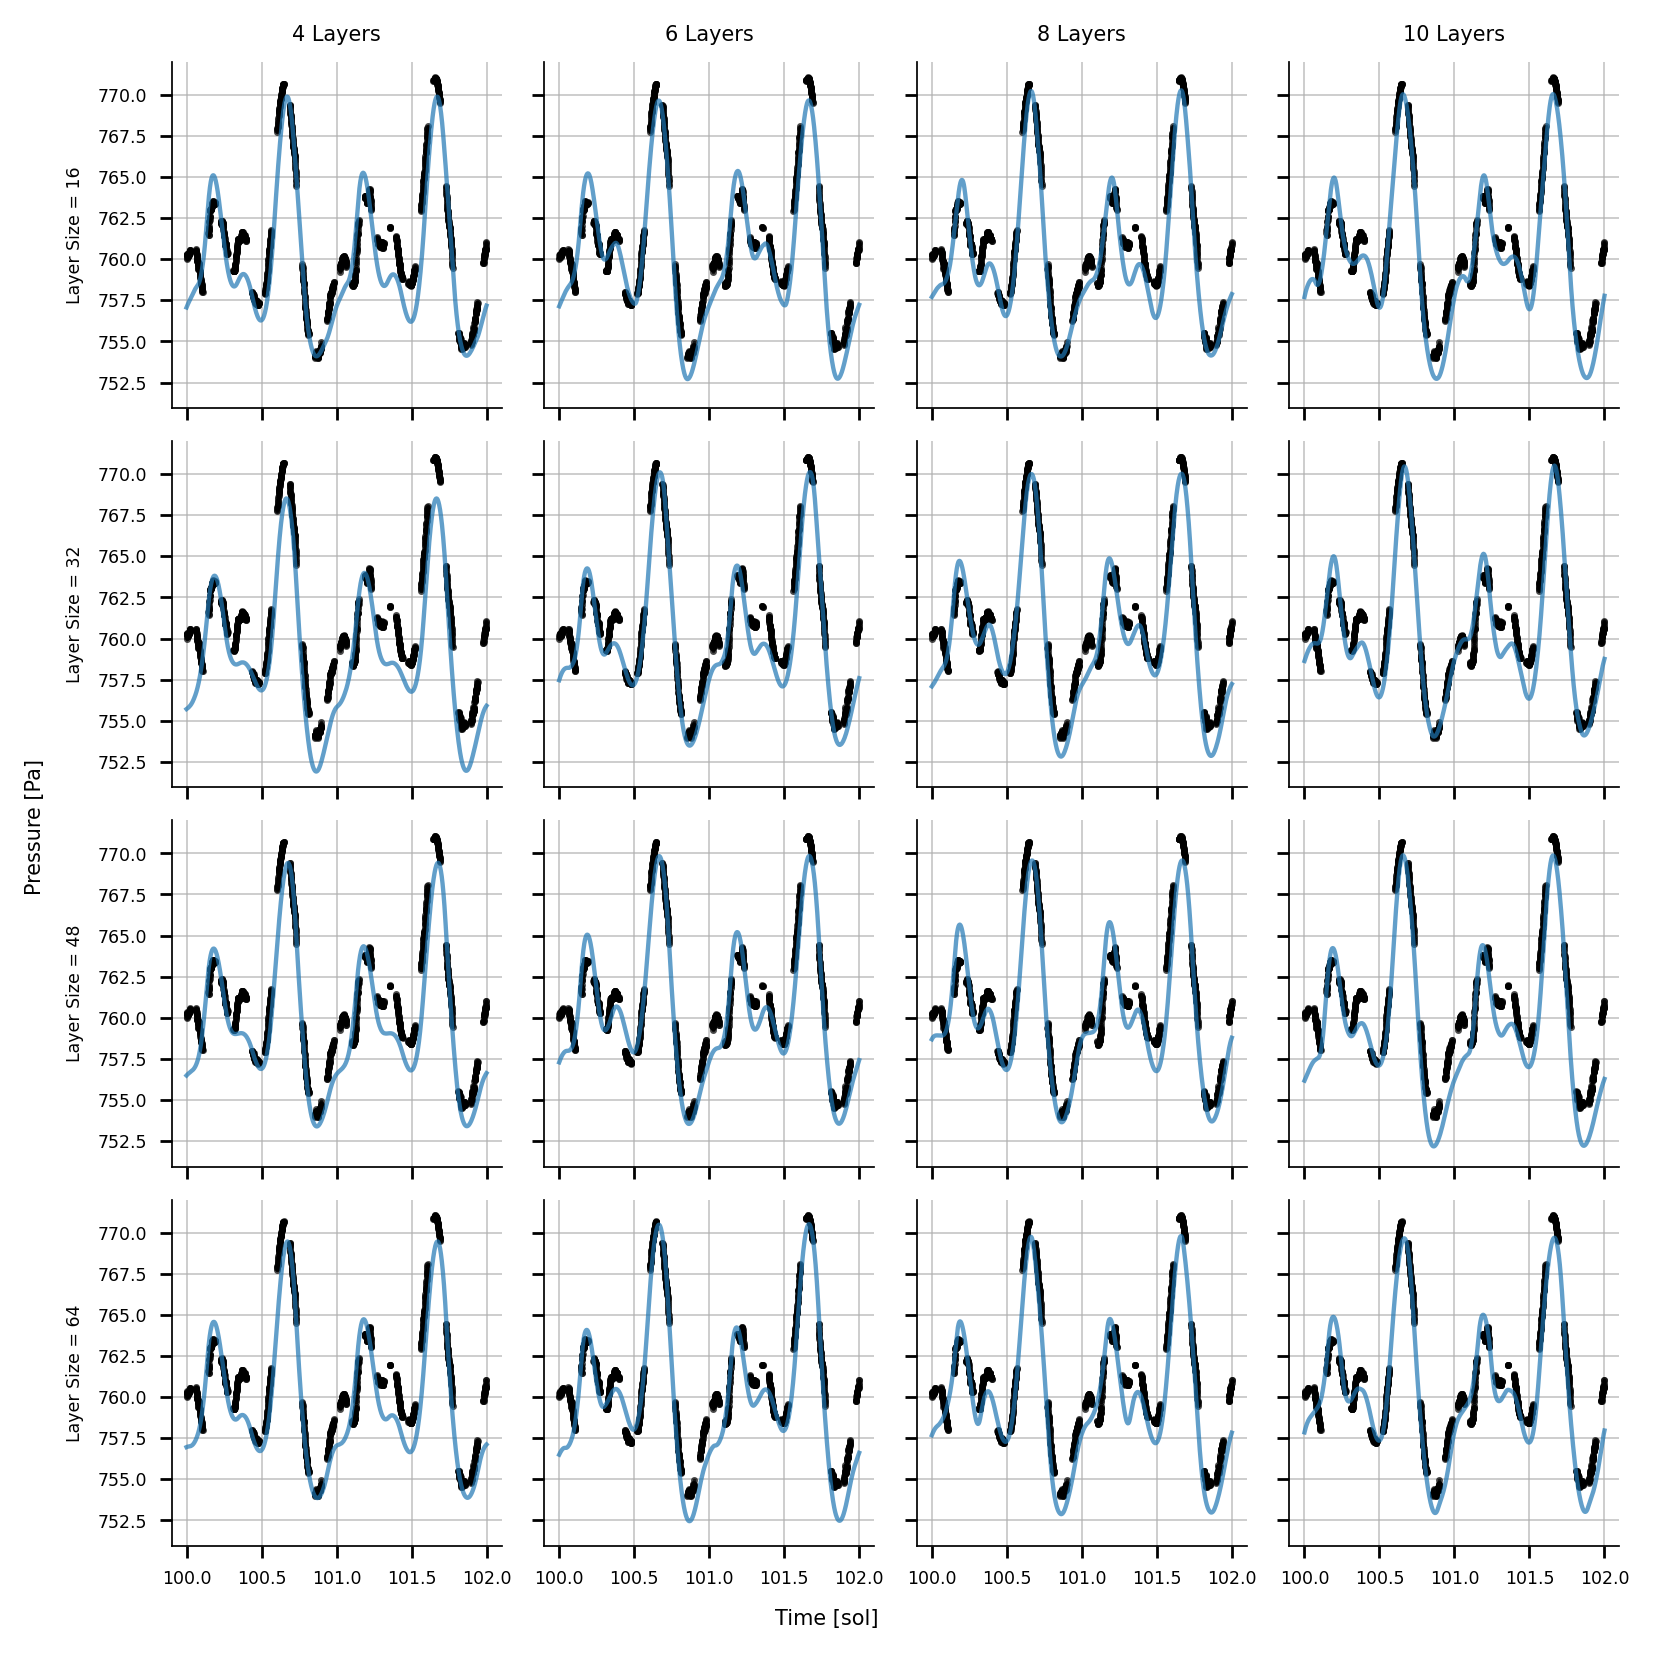

In [21]:
fig, axs = plt.subplots(
    length(hlayer),
    length(nlayer),
    figsize=(6.5,6.5),
    sharex=true,
    sharey=true,
    constrained_layout=true
)
sol = LinRange(100, 102, 100_000)
∿ = sinusoids(sol)
m = (@. 100 < df.sol < 102)
for i ∈ 1:length(hlayer), j ∈ 1:length(nlayer)
    axs[i,j].plot(df.sol[m], df.P[m], color="k", alpha=0.7, ".", markersize=2)
    axs[i,j].plot(sol, μ .+ σ*(∿ |> models[i,j] |> vec), alpha=0.7)
end
for i ∈ 1:length(hlayer)
    axs[i,1].set_ylabel("Layer Size = $(hlayer[i])")
end
for j ∈ 1:length(nlayer)
    axs[1,j].set_title("$(nlayer[j]) Layers")
end
fig.supxlabel("Time [sol]")
fig.supylabel("Pressure [Pa]");